# Lab Deep Learning/ Recurrent Neural Networks/ in keras

## Using Many-to-One for movie rating predicton

**Author: geoffroy.peeters@telecom-paris.fr**

**Version**: 2020/10/05 (changed to tensorfow.keras)
    
For any remark or suggestion, please feel free to contact me.

## Objective:
We will implement two different networks to perform automatic rating (0 or 1) of a movie given the text of its review.
We will use the ```imdb``` (internet movie database) dataset.

The reviews are already available in the form of indexes that point to a word dictionary: each word is already encoded as an index in the dictionary.

## Import packages

In [162]:
import numpy as np
from tensorflow.keras.datasets import imdb

from tensorflow.keras import backend as K
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.layers import Dense, Activation, Embedding, Dropout, Input, LSTM, Reshape, Lambda, RepeatVector

colab = False
student = True

## Parameters of the model

-  We only consider the ```top_words``` first words in the word dictionary
- We truncate/zero-pad each sequence a length ```max_review_length```

In [191]:
top_words = 5000
max_review_length = 100
INDEX_FROM = 2
embedding_vector_length = 32

## Import IMDB data

In [192]:
# --- Import the IMDB data and only consider the ``top_words``` most used words
np.load.__defaults__=(None, True, True, 'ASCII')
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=top_words, index_from=INDEX_FROM)
np.load.__defaults__=(None, False, True, 'ASCII')

## Data content

- ```X_train``` and ```X_test``` are numpy arrays of lists. 
  - each item in a list is the index in the word dictionary. So that a list is the sequence of index of words.

- ```y_train``` and ```y_test``` are a numpy arrays of the same dimension as ```X_train``` and ```X_test``` 
  - they contains the values 0 (bad movie) or 1 (good movie)

type(X_train): <class 'numpy.ndarray'>
number of training sequences: X_train.shape: (25000,)
type(X_train[0]): <class 'list'>
length of the first training sequence: len(X_train[0]): 218
length of the second training sequence: len(X_train[1]): 189
list of data of the first training sequence: X_train[0]: [1, 13, 21, 15, 42, 529, 972, 1621, 1384, 64, 457, 4467, 65, 3940, 3, 172, 35, 255, 4, 24, 99, 42, 837, 111, 49, 669, 2, 8, 34, 479, 283, 4, 149, 3, 171, 111, 166, 2, 335, 384, 38, 3, 171, 4535, 1110, 16, 545, 37, 12, 446, 3, 191, 49, 15, 5, 146, 2024, 18, 13, 21, 3, 1919, 4612, 468, 3, 21, 70, 86, 11, 15, 42, 529, 37, 75, 14, 12, 1246, 3, 21, 16, 514, 16, 11, 15, 625, 17, 2, 4, 61, 385, 11, 7, 315, 7, 105, 4, 3, 2222, 2, 15, 479, 65, 3784, 32, 3, 129, 11, 15, 37, 618, 4, 24, 123, 50, 35, 134, 47, 24, 1414, 32, 5, 21, 11, 214, 27, 76, 51, 4, 13, 406, 15, 81, 2, 7, 3, 106, 116, 2, 14, 255, 3, 2, 6, 3765, 4, 722, 35, 70, 42, 529, 475, 25, 399, 316, 45, 6, 3, 2, 1028, 12, 103, 87, 3, 380, 1

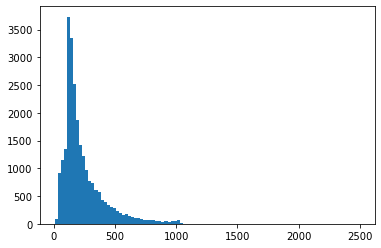

In [193]:
print("type(X_train):", type(X_train))
print("number of training sequences: X_train.shape:", X_train.shape)
print("type(X_train[0]):",type(X_train[0]))
print("length of the first training sequence: len(X_train[0]):",len(X_train[0]))
print("length of the second training sequence: len(X_train[1]):",len(X_train[1]))
print("list of data of the first training sequence: X_train[0]:", X_train[0] )
len_list = [len(train) for train in X_train]
print("maximum length of a training sequence:", max(len_list))

import matplotlib.pyplot as plt
plt.hist(len_list, 100);

## Details of how the reviews are encoded

In [194]:
word_to_id = imdb.get_word_index()
word_to_id = {k:(v+INDEX_FROM) for k,v in word_to_id.items()}
word_to_id["<PAD>"] = 0
word_to_id["<START>"] = 1
word_to_id["<UNK>"] = 2

id_to_word = {value:key for key,value in word_to_id.items()}
print(' '.join(id_to_word[id] for id in X_train[0] ))

<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly <UNK> was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little <UNK> that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big <UNK> for the whole film but these children are amazing and should be <UNK> for what they

In [195]:
print("type(y_train):", type(y_train))
print("y_train.shape:", y_train.shape)

type(y_train): <class 'numpy.ndarray'>
y_train.shape: (25000,)


In [196]:
print("X_test.shape:", X_test.shape)
print("y_test.shape:", y_test.shape)

X_test.shape: (25000,)
y_test.shape: (25000,)


## Data processing

Sequences (represented as a list of values) in ```X_train``` represent the reviews.
They can have different length.
To train the network we should modify them so that they all have the same length.
We do this by:
- truncating the ones that are too long
- padding-with-zero them the ones that are too short.

This is obtained using ```sequence.pad_sequences``` of keras.

In [197]:
# --- truncate and pad input sequences

if student:
    X_train = sequence.pad_sequences(X_train, maxlen=max_review_length, value=0)
    X_test = sequence.pad_sequences(X_test, maxlen=max_review_length, value=0)

print("len(X_train[0]):", len(X_train[0]))
print("len(X_train[1]):", len(X_train[1]))
print("X_train[0]:", X_train[0])

len(X_train[0]): 100
len(X_train[1]): 100
X_train[0]: [1414   32    5   21   11  214   27   76   51    4   13  406   15   81
    2    7    3  106  116    2   14  255    3    2    6 3765    4  722
   35   70   42  529  475   25  399  316   45    6    3    2 1028   12
  103   87    3  380   14  296   97   31 2070   55   25  140    5  193
    2   17    3  225   21   20  133  475   25  479    4  143   29    2
   17   50   35   27  223   91   24  103    3  225   64   15   37 1333
   87   11   15  282    4   15 4471  112  102   31   14   15    2   18
  177   31]


# First model

<img src="https://perso.telecom-paristech.fr/gpeeters/doc/Lab_DL_RNN_01.png">

In the first model, we will simply 
- learn a word embedding  (```Embedding``` layer in keras) and apply it to each item of the sequence, 
  -  in keras, embedding is not a matrix going from one-hot-encoding to embedding, but is a layer that goes from index-in-word-dictionary to embedding
  - the embedding goes from ```top_words``` dimensions to  ```embedding_vector_length``` dimensions
- average the embedding obtained for each word of a sequence over all words of the sequence (you should use ```K.mean``` and ```Lambda``` from the keras backend)
- apply a fully connected (```Dense``` layer in keras) which output activation is a sigmoid (predicting the 0 or 1 rating)

We will code this model 
- First, using the Sequential API of keras (https://keras.io/models/sequential/)
- Secondly, using the Functional API of keras (https://keras.io/getting-started/functional-api-guide/)


In [198]:
K.clear_session()

In [199]:
# --- create the model
# CODE-RNN1-2
if student:
    # --- START CODE HERE (02)
    # --- Using the Sequential API
    model = Sequential(
        [
            Embedding(top_words, embedding_vector_length, input_length=max_review_length),
            Lambda(K.mean, arguments={'axis': 1}),
            Dense(1, activation='sigmoid')
        ]
    )
    
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 32)           160000    
_________________________________________________________________
lambda (Lambda)              (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_________________________________________________________________
None


In [200]:
# --- compile and fit the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))

Train on 25000 samples, validate on 25000 samples
Epoch 1/10
25000/25000 [==============================] - 2s 72us/sample - loss: 0.6380 - acc: 0.7226 - val_loss: 0.5616 - val_acc: 0.7767
Epoch 2/10
25000/25000 [==============================] - 2s 71us/sample - loss: 0.4862 - acc: 0.8146 - val_loss: 0.4403 - val_acc: 0.8194
Epoch 3/10
25000/25000 [==============================] - 2s 72us/sample - loss: 0.3940 - acc: 0.8440 - val_loss: 0.3848 - val_acc: 0.8368
Epoch 4/10
25000/25000 [==============================] - 2s 71us/sample - loss: 0.3471 - acc: 0.8583 - val_loss: 0.3592 - val_acc: 0.8441
Epoch 5/10
25000/25000 [==============================] - 2s 68us/sample - loss: 0.3187 - acc: 0.8706 - val_loss: 0.3453 - val_acc: 0.8494
Epoch 6/10
25000/25000 [==============================] - 2s 71us/sample - loss: 0.2990 - acc: 0.8780 - val_loss: 0.3378 - val_acc: 0.8514
Epoch 7/10
25000/25000 [==============================] - 2s 68us/sample - loss: 0.2844 - acc: 0.8840 - val_loss: 0.

## Results

After only 3 epochs, you should obtain an accuracy around 84% for the test data.

In [201]:
# --- Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 85.35%


## Using the trained embedding to find equivalence between words

Since the embedding is part of the models, we can look at the trained embedding matrix $E$ and use it to get the most similar words (according to the trained matrix $E$) in the dictionary.
Use the weights of the ```Embedding``` layer to find the most similar words to ```great```. We will use an Euclidean distance for that.
- Retrieve the weights of the ```Embedding layer```
- Get the position of ```great``` in the dictionary
- Get the word-embedding of ```great```
- Find (using Euclidean distance), the closest embedded-words to ```great```

In [205]:
if student:
    E = model.layers[0].get_weights()[0]
    great_id = word_to_id['great']
    great_embedding = E[great_id, :]
    
    distances = {
        idx: np.linalg.norm(great_embedding - embedding) for idx, embedding in enumerate(E) if idx != great_id
    }
    
    distances_sorted = {k:v for k, v in sorted(distances.items(), key=lambda item: item[1])}
    
    for idx, key in enumerate(distances_sorted.keys()):
        print(id_to_word[key])
        
        if idx==5:
            break

fantastic
friendship
rare
favorites
delight
outstanding


# Second model

In the second model, we will replace
- the average over the sequence of the obtained embedding
- by a RNN layer (more precisely an ```LSTM```) in a Many-To-One configuration with $n_a=128$

We will code this model 
- First, using the Sequential API of keras (https://keras.io/models/sequential/)
- Secondly, using the Functional API of keras (https://keras.io/getting-started/functional-api-guide/)



In [14]:
K.clear_session()

In [211]:
# --- create the model

if student:
    model = Sequential(
        [
            Embedding(top_words, embedding_vector_length, input_length=max_review_length),
            LSTM(128, activation='sigmoid'),
            Dense(1, activation='sigmoid')
        ]
    )
    
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 32)           160000    
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               82432     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 242,561
Trainable params: 242,561
Non-trainable params: 0
_________________________________________________________________
None


In [212]:
# --- compile and fit the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=3, batch_size=64, validation_data=(X_test, y_test))

Train on 25000 samples, validate on 25000 samples
Epoch 1/3
25000/25000 [==============================] - 102s 4ms/sample - loss: 0.5790 - acc: 0.6601 - val_loss: 0.3749 - val_acc: 0.8358
Epoch 2/3
25000/25000 [==============================] - 105s 4ms/sample - loss: 0.3410 - acc: 0.8524 - val_loss: 0.3404 - val_acc: 0.8511
Epoch 3/3
25000/25000 [==============================] - 110s 4ms/sample - loss: 0.2867 - acc: 0.8824 - val_loss: 0.3622 - val_acc: 0.8478


## Results

After only 3 epochs, you should obtain an accuracy around 88% for the test data.

In [210]:
# --- Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100)) 

Accuracy: 85.03%


# Evaluation

To evaluate the work, you should rate the code for 
- 1) Data Pre-Processing (01)
- 2) First model using the Sequential API (02)
- 3) First model using the Functional API (03)
- 4) Find equivalence between words (04)
- 5) Second model using the Sequential API (05)
- 6) Second model using the Functional API (06)
